In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr, moving_sum, viztraj3D, load_datasets, rostraj2aug, merge_traj
from trajgen import quadratic, nonlinear, quadrotor

## Load trajectory from files

In [30]:
# Original min-jerk traj, very clean data
mjtraj = np.load('rostraj/processed/orig.pkl', allow_pickle=True)

# OOD data from experiment
oodtraj = np.load('rostraj/processed/ood.pkl', allow_pickle=True)

# Augmentation data iteration 1
it1traj = np.load('rostraj/processed/it1.pkl', allow_pickle=True)

In [31]:
# Merge the trajectory
xtraj, xtraj_, utraj, rtraj, vtraj = merge_traj([mjtraj, oodtraj, it1traj])

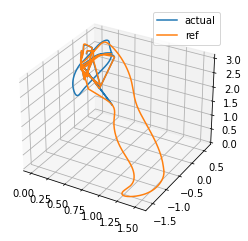

In [36]:
# Visualize trajectory
tt1 = -2000
tt2 = -1
viztraj3D([xtraj[tt1:tt2:,:3].T, xtraj[tt1:tt2:,14:17].T],['actual', 'ref'])

## Train NNs

In [37]:
# Parameters
Tref = 300
gamma = 0.99

In [38]:
# Shuffle the data
inds = np.arange(xtraj.shape[0])
#np.random.shuffle(inds)
xtrain, utrain, rtrain, xtrain_, vtrain = xtraj[inds], utraj[inds], rtraj[inds], xtraj_[inds], vtraj[inds]
print('Number of samples in the dataset:', xtrain.shape[0])

Number of samples in the dataset: 108941


In [39]:
# Construct a dataset of transitions
TT = 108941

dataset = trajdata.TrajDataset(xtrain[:TT], utrain[:TT], rtrain[:TT], xtrain_[:TT], vtrain[:TT])
dataset.cuda()

In [22]:
# Create a network
icnnvalue = valuefunc.ICNNValueFunc(xtraj.shape[1], [100, 100, 1])
icnnvalue.cuda()

# Train the network on (x,y,z) data and see how it behaves
gamma = 0.99
icnnvalue.learn(dataset, gamma, num_epoch=2000, batch_size=64, verbose=True,
                print_interval=10, lr=0.0005, beta=0.7)
#torch.save(mlpvalue, 'models/icnnit2.pt')

Epoch: 1 	 Training loss: 307161.93572668004
Epoch: 11 	 Training loss: 106156.06881717451
Epoch: 21 	 Training loss: 35.76438440115082
Epoch: 31 	 Training loss: 122.41609672798212
Epoch: 41 	 Training loss: 562.3428430519841
Epoch: 51 	 Training loss: 52.93311790171323
Epoch: 61 	 Training loss: 758.9915192225667
Epoch: 71 	 Training loss: 234.98242485614634
Epoch: 81 	 Training loss: 65.84301073319111
Epoch: 91 	 Training loss: 60.5322424714974
Epoch: 101 	 Training loss: 83.2232805701491
Epoch: 111 	 Training loss: 57.452510512152315
Epoch: 121 	 Training loss: 54.18347438298759
Epoch: 131 	 Training loss: 71.54414543506346
Epoch: 141 	 Training loss: 417.33222925576825
Epoch: 151 	 Training loss: 51.12027951491674
Epoch: 161 	 Training loss: 127.25248860469944
Epoch: 171 	 Training loss: 36.962128101509066
Epoch: 181 	 Training loss: 424.0203653519294
Epoch: 191 	 Training loss: 25.09550212327771
Epoch: 201 	 Training loss: 416.6578169216965
Epoch: 211 	 Training loss: 403.3542936

Epoch: 1761 	 Training loss: 12.982402041461775
Epoch: 1771 	 Training loss: 28.798732806334858
Epoch: 1781 	 Training loss: 10.313233902748728
Epoch: 1791 	 Training loss: 65.11261101147512
Epoch: 1801 	 Training loss: 710.0648815549183
Epoch: 1811 	 Training loss: 10.901061516393806
Epoch: 1821 	 Training loss: 202.2372148790087
Epoch: 1831 	 Training loss: 9.495403308636583
Epoch: 1841 	 Training loss: 6.748852265719545
Epoch: 1851 	 Training loss: 12.829258788722715
Epoch: 1861 	 Training loss: 372.70537237341426
Epoch: 1871 	 Training loss: 4.466368561825734
Epoch: 1881 	 Training loss: 42.733766486067054
Epoch: 1891 	 Training loss: 83.78578770442978
Epoch: 1901 	 Training loss: 410.24148919865036
Epoch: 1911 	 Training loss: 25.718183881754527
Epoch: 1921 	 Training loss: 180.6448562267411
Epoch: 1931 	 Training loss: 56.29833195973515
Epoch: 1941 	 Training loss: 396.6667569783647
Epoch: 1951 	 Training loss: 11.637635732371995
Epoch: 1961 	 Training loss: 30.70837359029434
Epo

In [45]:
# Create a network
mlpvalue = valuefunc.MLPValueFunc(xtraj.shape[1], [80, 80, 1])
mlpvalue.cuda()

# Train the network on (x,y,z) data and see how it behaves
mlpvalue.learn(dataset, gamma, num_epoch=2000, batch_size=64, verbose=True,
               print_interval=10, lr=0.0005, beta=1)
#torch.save(mlpvalue, 'models/mlpit2.pt')

Epoch: 1 	 Training loss: 68.61932080412808
Epoch: 11 	 Training loss: 17.941511158951116
Epoch: 21 	 Training loss: 39.46880630687161
Epoch: 31 	 Training loss: 1.32784984690182
Epoch: 41 	 Training loss: 8.270147820689884
Epoch: 51 	 Training loss: 4.851083550744045
Epoch: 61 	 Training loss: 16.16589116612652
Epoch: 71 	 Training loss: 1.281605499356639
Epoch: 81 	 Training loss: 4.588240210899894
Epoch: 91 	 Training loss: 6.079496622059066
Epoch: 101 	 Training loss: 4.697933676714977
Epoch: 111 	 Training loss: 3.2946266452616695
Epoch: 121 	 Training loss: 7.563556709124569
Epoch: 131 	 Training loss: 42.71674918236169
Epoch: 141 	 Training loss: 11.983028357292097
Epoch: 151 	 Training loss: 15.567719855374136
Epoch: 161 	 Training loss: 2.2463295423324907
Epoch: 171 	 Training loss: 6.303857790964871
Epoch: 181 	 Training loss: 13.6749184648117
Epoch: 191 	 Training loss: 5.072907076086274
Epoch: 201 	 Training loss: 1.6037815962924777
Epoch: 211 	 Training loss: 2.08016575627

Epoch: 1751 	 Training loss: 5.043376318812711
Epoch: 1761 	 Training loss: 3.020692543327068
Epoch: 1771 	 Training loss: 1.2256968945808513
Epoch: 1781 	 Training loss: 19.468089303967815
Epoch: 1791 	 Training loss: 3.333003461722319
Epoch: 1801 	 Training loss: 3.040336791119311
Epoch: 1811 	 Training loss: 1.2269536876832552
Epoch: 1821 	 Training loss: 0.6872929789624922
Epoch: 1831 	 Training loss: 0.722395950613487
Epoch: 1841 	 Training loss: 15.095511687093552
Epoch: 1851 	 Training loss: 0.9476097137413035
Epoch: 1861 	 Training loss: 1.5152303168150467
Epoch: 1871 	 Training loss: 0.7168653760686071
Epoch: 1881 	 Training loss: 74.96604040240459
Epoch: 1891 	 Training loss: 5.4617659491149135
Epoch: 1901 	 Training loss: 3.0799563117454434
Epoch: 1911 	 Training loss: 10.284532629530053
Epoch: 1921 	 Training loss: 1.4430947691784832
Epoch: 1931 	 Training loss: 2.9697644128638356
Epoch: 1941 	 Training loss: 2.307145929174512
Epoch: 1951 	 Training loss: 3.781042794978366


In [51]:
# Create a network
convvalue = valuefunc.ConvValueFunc()
convvalue.cuda()

In [64]:
# Train the network on (x,y,z) data and see how it behaves
convvalue.learn(dataset, gamma, num_epoch=2000, batch_size=64, verbose=True,
               print_interval=10, lr=0.0005, beta=1)

Epoch: 1 	 Training loss: 50.898350750199334
Epoch: 11 	 Training loss: 11.51249097793455
Epoch: 21 	 Training loss: 14.752588931331017
Epoch: 31 	 Training loss: 6.243574717440423
Epoch: 41 	 Training loss: 22.942163170827932
Epoch: 51 	 Training loss: 13.070175930073452
Epoch: 61 	 Training loss: 20.196329237274433
Epoch: 71 	 Training loss: 4.235564284501418
Epoch: 81 	 Training loss: 3.6758554687744454
Epoch: 91 	 Training loss: 15.65459025202885
Epoch: 101 	 Training loss: 5.185962284071301
Epoch: 111 	 Training loss: 31.88395076087349
Epoch: 121 	 Training loss: 14.534145333247677
Epoch: 131 	 Training loss: 2.6338610445890906
Epoch: 141 	 Training loss: 2.2322260328183003
Epoch: 151 	 Training loss: 12.38057865883274
Epoch: 161 	 Training loss: 3.281874705137682
Epoch: 171 	 Training loss: 4.9545355275276055
Epoch: 181 	 Training loss: 6.1672838378138435
Epoch: 191 	 Training loss: 3.8710133557805437
Epoch: 201 	 Training loss: 3.505139139931971
Epoch: 211 	 Training loss: 8.815

KeyboardInterrupt: 

## Test whether NNs learned

In [42]:
%matplotlib notebook

<IPython.core.display.Javascript object>


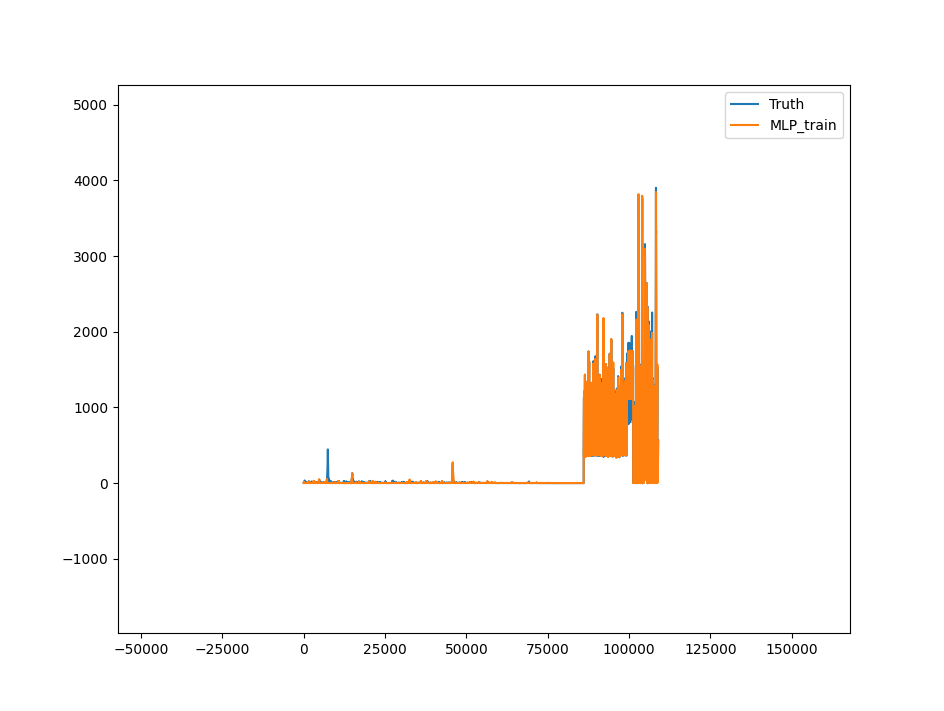

In [68]:
# Move model to cpu first
mlpvalue.cpu()
icnnvalue.cpu()
convvalue.cpu()

# Test whether NNs memorized the training data
Tstart = 0
Tend = -1
train_x = xtraj[Tstart:Tend]
test_x = xtraj[Tend:]
test_cost = rtraj[:, 0]

# Compute the true values
plt.plot(vtraj, label='Truth')

# Compute the cost from NN
#icnn_values = icnnvalue.network(torch.tensor(xtraj[Tstart:Tend]))[:,0].detach()
#plt.plot(icnn_values, label='ICNN')
mlp_train = convvalue.network(torch.tensor(xtraj))[:,0].detach()
plt.plot(mlp_train, label='MLP_train')
#plt.plot(np.arange(xtraj.shape[0]-TT)+TT, mlp_test, 'r', label='MLP Test')
plt.legend()

## Generate trajectory

In [128]:
# Generate trajectory on only x,y,z
segments = 2
waypoints = np.random.randn(4, segments+1)
ts = np.linspace(0,1,segments+1) * 3

In [161]:
rho = 0
order = 6

_, minjerk_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, 4, None, 0)
nn_coeff = quadrotor.generate(torch.tensor(waypoints), ts, order, Tref, 4, rho, icnnvalue, 
                              torch.randn(minjerk_coeffs.shape).double(), num_iter=20, lr=0.01)

In [162]:
t, fullmj_traj = quadrotor.coeff2traj(minjerk_coeffs, ts, 1000)
t, fullnn_traj = quadrotor.coeff2traj(nn_coeff, ts, 1000)

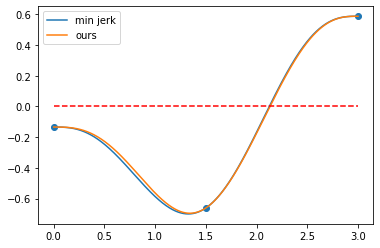

In [163]:
plt.scatter(ts, waypoints[2])
plt.plot(t, fullmj_traj[2], label='min jerk')
plt.plot(t, fullnn_traj[2], label='ours')
plt.plot(t, np.zeros(1000), 'r--')
plt.legend()

In [164]:
%matplotlib inline

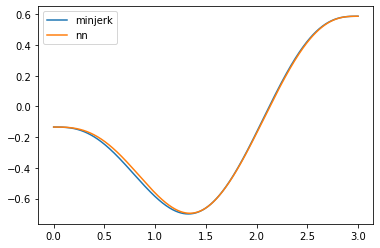

In [170]:
dim = 2
plt.plot(t, fullmj_traj[dim], label='minjerk')
plt.plot(t, fullnn_traj[dim], label='nn')
plt.legend()

/home/fengjun/.virtualenvs/general/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/fengjun/.virtualenvs/general/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, n

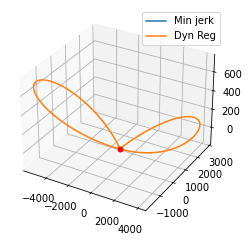

In [138]:
# Visualize trajectory
viztraj3D([fullmj_traj[:3], fullnn_traj[:3]], ['Min jerk', 'Dyn Reg'], waypoints)

In [69]:
coeffs = np.load('results/f3_coeffs_good_model_lr0.002.pkl', allow_pickle=True)

In [94]:
ts = np.linspace(0, 3, 6 + 1)

def find_distance(coeff, xtraj):
    quadrotor.coeff2traj(coeff, ts, 300)
    _, xx = quadrotor.coeff2traj(coeff, ts, 300)
    d = torch.cat([xx[:,0], xx.T.flatten()]).numpy()
    norms = np.linalg.norm(xtraj - d, axis=1)
    return norms.min()

In [105]:
#dist = np.zeros((10, 20))
for i in range(2):
    for j in range(20):
        print(j, end=',')
        dist[i][j] = find_distance(coeffs[i][j], xtraj)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

In [106]:
dist

array([[140.63900664, 140.7125891 , 141.07252147, 142.04693241,
        143.97775914, 147.10444877, 151.22584914, 156.15024661,
        161.66669872, 167.52854064, 173.4447332 , 178.97193315,
        183.55084065, 186.85785632, 188.82424236, 189.41590371,
        188.87478445, 187.69434174, 186.25073179, 184.72324072],
       [ 88.33772459,  88.47722325,  88.9682037 ,  90.14565559,
         92.3620239 ,  95.74771324,  99.92878919, 105.10221087,
        110.8483523 , 116.82248622, 122.76837834, 128.47475114,
        133.74274675, 138.48906145, 142.65346778, 144.4502524 ,
        145.35439629, 145.82123472, 145.82373592, 145.40551959],
       [164.73072396, 165.92913714, 170.2645461 , 178.42363231,
        187.9773914 , 197.535332  , 206.19509273, 213.27141826,
        218.40990954, 221.69443633, 223.21427797, 223.16763014,
        222.06697189, 220.23528162, 217.98897876, 215.52862822,
        213.03415928, 210.72565549, 208.69904257, 206.8141052 ],
       [146.33523323, 146.36164894, 1

<IPython.core.display.Javascript object>


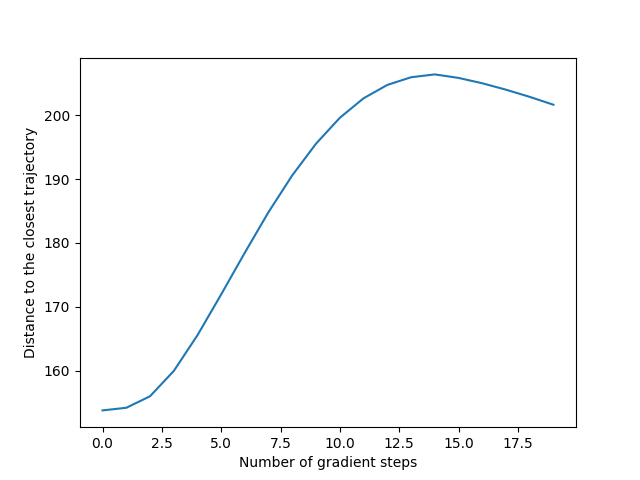

Text(0, 0.5, 'Distance to the closest trajectory')

In [108]:
plt.plot(dist[0:5].mean(0))
plt.xlabel('Number of gradient steps')
plt.ylabel('Distance to the closest trajectory')

In [98]:
def generate_lissajous_traj(s, x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp, y_amp, z_amp, yaw_amp):
    """
    Function to generate Lissajous trajectory
    :return:
    """
    x = lambda a: x_amp * (1 - np.cos(2 * np.pi * x_num_periods * a / period))
    y = lambda a: y_amp * np.sin(2 * np.pi * y_num_periods * a / period)
    z = lambda a: z_amp * np.sin(2 * np.pi * z_num_periods * a / period)
    yaw = lambda a: yaw_amp * np.sin(2 * np.pi * yaw_num_periods * a / period)
    return [x(s), y(s), z(s), yaw(s)]

def generate_waypoint():
    # Testing on Lissajous curve
    x_amp = 0.5 * np.random.random()
    y_amp = 0.5 * np.random.random()
    z_amp = 0.5 * np.random.random()
    yaw_amp = 0.3414 * np.random.random()
    x_num_periods = 1
    y_num_periods = 1
    z_num_periods = 1
    yaw_num_periods = 1
    period = 3 #+ np.random.random()
    ref = generate_lissajous_traj(np.linspace(0, 3, 301), x_num_periods, y_num_periods, z_num_periods, yaw_num_periods,
                                      period, x_amp,
                                      y_amp, z_amp, yaw_amp)
    p = 4  # 4-dim x, y, z, yaw
    segments = 6  
    ts = np.linspace(0, 3, segments + 1)
    order = 5
    Tref = 300
    waypt = np.array(ref)[:, 0::50]  # 7 waypoints equally spaced
    offset = min(waypt[2, :])  
    #print("Negative offset", offset)
    waypt[2, :] = waypt[2, :] - offset + 1  # To make sure z axis is at roughly 1m
    return waypt, ts

In [100]:
order = 5
np.random.seed(i + 100)
waypoints, ts = generate_waypoint()
durations = ts[1:] - ts[:-1]

# Do gradient descent
exp_coeffs = []
exp_regs = []
_, minjerk_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, 4, None, 0)